In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import gzip
import codecs
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
from sklearn.linear_model import LinearRegression
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [3]:
fastapath = "data/genome/hg38/hg38.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 1346
out_pred_len = 1000
test_chrms = ["chr1", "chr8", "chr21"]
peaks = []
bedfile = "/oak/stanford/groups/akundaje/amr1/pho4/data/a549_GR/tseries/2hr/2hr.bed.gz"
with gzip.open(bedfile, 'rt') as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + int(line.strip().split('\t')[-1])
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        peaks.append(GenomeDict[chrm][start:end].upper())

In [4]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def fill_into_center(seq, insert):
    start = int((len(seq)/2.0)-(len(insert)/2.0))
    new_seq = seq[:start]+insert+seq[start+len(insert):]
    return new_seq

ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [5]:
def generate_matrix(seq):
    seq_matrix = np.zeros((4, len(seq)))
    for j in range(len(seq)):
        if seq[j] == 'A':
            seq_matrix[0,j] = 1
        elif seq[j] == 'C':
            seq_matrix[1,j] = 1
        elif seq[j] == 'G':
            seq_matrix[2,j] = 1
        elif seq[j] == 'T':
            seq_matrix[3,j] = 1
    return seq_matrix
def get_PSAM_score(sequence, score_matrix):
    score = 0
    score_len = score_matrix.shape[0]
    for j in range(len(sequence) - score_len + 1):
        seq_matrix = generate_matrix(sequence[j:j+score_len])
        diagonal = np.diagonal(np.matmul(score_matrix,seq_matrix))
        score += np.prod(diagonal)
    return score
def get_PWM_score(sequence, score_matrix):
    score = 0
    score_len = score_matrix.shape[0]
    for j in range(len(sequence) - score_len + 1):
        seq_matrix = generate_matrix(sequence[j:j+score_len])
        diagonal = np.diagonal(np.matmul(score_matrix,seq_matrix))
        score = np.maximum(score, np.sum(diagonal))
    return score

def ddG(Kd1, Kd2, R=1.9872036e-3, T=295):
    return R*T*np.log(Kd2/Kd1)

In [6]:
# lines = []
# with open('/Users/connor/Documents/fordycelab/Maerkl_Quake_data/PHO4_PSAM_MaerklQuake2007.csv') as handle:
#     reader = csv.reader(handle)
#     for row in reader:
#         lines.append(row)
# Pho4_PSAM = np.array(lines)[1:,1:].T.astype('float')

In [7]:
!cat data/experimental/PSAMs/GR_PSAM_Pollymeasurements.csv

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
A,1.0,0.3847327846395602,0.9347039887492387,1.0,0.04701346834049215,1.0,0.6189135328243149,0.8436896757457115,0.8826498538927376,0.3638458522372175,0.08572154058116886,0.17616403693818353,0.7727133878772953,0.2872816391473612,0.5598293423415454
C,0.8974335169087382,0.1931913155874595,0.7665537368413462,0.10194806200027236,1.0,0.15499546928548913,1.0,1.0,0.8372844836561458,0.9360815177871751,0.06864095066836838,0.28513167598149697,0.9609526746276463,1.0,0.5440153259053587
G,0.820557430856223,1.0,0.7789302802129148,0.14116174261825182,0.019491306799740094,0.6320645926591755,0.43497408994221765,0.5746208167238983,0.8396261183047686,0.10988641276487936,1.0,0.18700206395020466,0.489289726783025,0.18048341558334374,0.6809256885076538
T,0.6671497224363918,0.2913496709715903,1.0,0.0997504894332275,0.0802002818240821,0.2880187091336975,0.7426852590396471,0.9968956962653354,1.0,1.0,0.04861798562587484,1.0,1.0,0.35447662614159386,1.0


In [8]:
import csv
import numpy as np

lines = []
with open('data/experimental/PSAMs/GR_PSAM_Pollymeasurements.csv') as handle:
    reader = csv.reader(handle)
    for row in reader:
        lines.append(row)
GR_PSAM = np.array(lines)[1:,1:].T.astype('float')

In [9]:
GR_PSAM

array([[1.        , 0.89743352, 0.82055743, 0.66714972],
       [0.38473278, 0.19319132, 1.        , 0.29134967],
       [0.93470399, 0.76655374, 0.77893028, 1.        ],
       [1.        , 0.10194806, 0.14116174, 0.09975049],
       [0.04701347, 1.        , 0.01949131, 0.08020028],
       [1.        , 0.15499547, 0.63206459, 0.28801871],
       [0.61891353, 1.        , 0.43497409, 0.74268526],
       [0.84368968, 1.        , 0.57462082, 0.9968957 ],
       [0.88264985, 0.83728448, 0.83962612, 1.        ],
       [0.36384585, 0.93608152, 0.10988641, 1.        ],
       [0.08572154, 0.06864095, 1.        , 0.04861799],
       [0.17616404, 0.28513168, 0.18700206, 1.        ],
       [0.77271339, 0.96095267, 0.48928973, 1.        ],
       [0.28728164, 1.        , 0.18048342, 0.35447663],
       [0.55982934, 0.54401533, 0.68092569, 1.        ]])

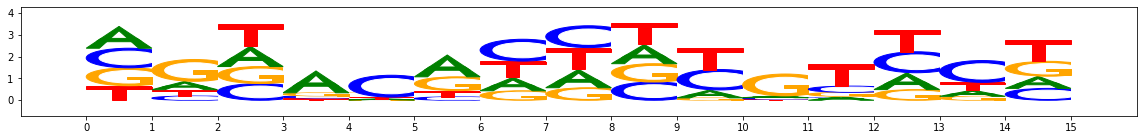

In [10]:
import matplotlib
from deeplift.visualization import viz_sequence
%matplotlib inline

viz_sequence.plot_weights(GR_PSAM)

In [11]:
GR_ddG = [[-ddG(x,1) for x in j] for j in GR_PSAM]
GR_ddG = np.array([i-np.mean(i) for i in GR_ddG])

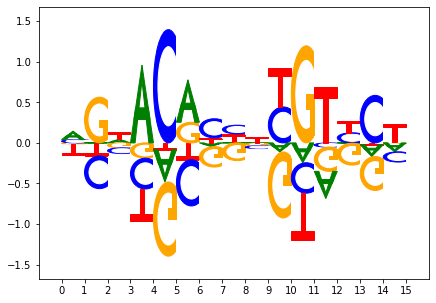

In [12]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, GR_ddG,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

In [13]:
get_PSAM_score("TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT", GR_PSAM)

9.714880924101293e-05

In [14]:
get_PSAM_score("TTTTTTTTTTTTTTTT", GR_PSAM)

1.1429271675413284e-05

In [15]:
get_PSAM_score("TTTTTTTTTACACCTTGTTTTTTTTT", GR_PSAM)

0.06929699746694691

In [16]:
get_PSAM_score("TTTACACCTTGTTTT", GR_PSAM)

0.06890098730986621

In [17]:
get_PSAM_score("AGTACACCTTGTTCT", GR_PSAM)

1.0

In [18]:
R=1.9872036e-3
T=295
R*T*np.log(get_PSAM_score("AGTACACCTTGTTCT", GR_PSAM))

0.0

In [19]:
consensus = "AGTACACCTTGTTCT"

In [20]:
seqs = []
for idx in range(len(consensus)):
    for cx in ['A', 'C', 'G', 'T']:
        for idy in range(idx+1, len(consensus)):
            for cy in ['A', 'C', 'G', 'T']:
                new_seq = list(consensus)
                new_seq[idx] = cx
                new_seq[idy] = cy
                seqs.append("".join(new_seq))
seqs = list(set(seqs))

In [21]:
len(seqs)

991

In [22]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("data/models/a5_tseries_model_2hr.h5")







Instructions for updating:
Use `tf.cast` instead.


In [23]:
num_samples = 100
seqToDeltaLogCount = {}
seqToPSAMScore = {}
for curr_seq in seqs:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(peaks), num_samples, replace=False)
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, curr_seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    seqToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])
    seqToPSAMScore[curr_seq] = get_PSAM_score(curr_seq, GR_PSAM)

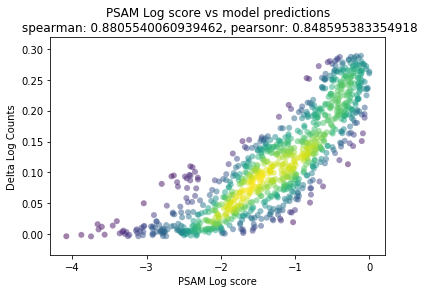

In [24]:
xvals = []
yvals = []

for seq in seqs:
    xvals.append(seqToPSAMScore[seq])
    yvals.append(seqToDeltaLogCount[seq])

xvals = R*T*np.log(xvals)

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts")
plt.title("PSAM Log score vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [25]:
building_blocks = []
for idx in range(len(consensus)):
    for cx in ['A', 'C', 'G', 'T']:
        if consensus[idx] == cx: continue
        new_seq = list(consensus)
        new_seq[idx] = cx
        building_blocks.append("".join(new_seq))

buildingBlocksToDeltaLogCount = {}
for curr_seq in building_blocks:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(peaks), num_samples, replace=False)
    for idx in indices:
        base_seq = dinuc_shuffle(peaks[idx])
        pre_seq = fill_into_center(base_seq, consensus)
        post_seq = fill_into_center(base_seq, curr_seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    buildingBlocksToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])

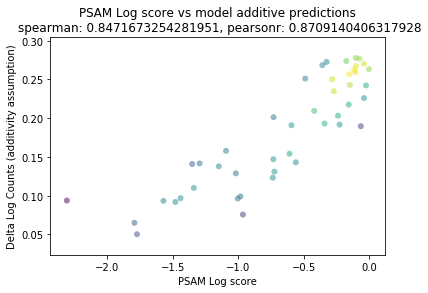

In [26]:
xvals = []
yvals = []

for seq in building_blocks:
    xvals.append(seqToPSAMScore[seq])
    yvals.append(seqToDeltaLogCount[consensus] + buildingBlocksToDeltaLogCount[seq])

xvals = R*T*np.log(xvals)

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts (additivity assumption)")
plt.title("PSAM Log score vs model additive predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [27]:
for seq in building_blocks:
    if R*T*np.log(seqToPSAMScore[seq]) < -2: print(seq)

AGTAGACCTTGTTCT


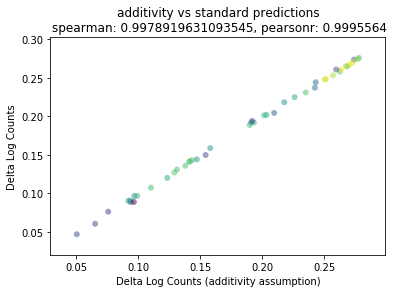

In [28]:
xvals = []
yvals = []

for seq in building_blocks:
    xvals.append(seqToDeltaLogCount[consensus]+buildingBlocksToDeltaLogCount[seq])
    yvals.append(seqToDeltaLogCount[seq])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

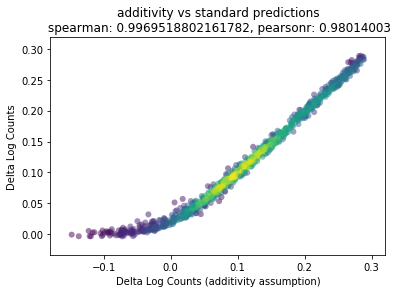

In [29]:
xvals = []
yvals = []

for seq in seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    xvals.append(score)
    yvals.append(seqToDeltaLogCount[seq])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

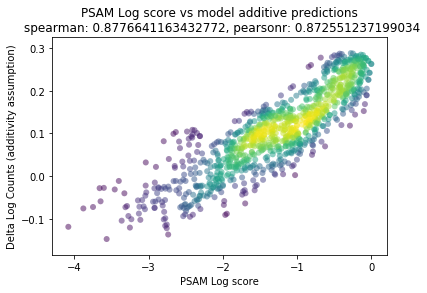

In [30]:
xvals = []
yvals = []

for seq in seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    yvals.append(score)
    xvals.append(seqToPSAMScore[seq])

xvals = R*T*np.log(xvals)

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts (additivity assumption)")
plt.title("PSAM Log score vs model additive predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [31]:
seqToDdg = {}
firstLine = True
with open("data/experimental/GR_bindingcurves_WT_1_out.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        Oligo,Kd_estimate,ddG,Motif,Sequence = line.strip().split(',')
        seq = Sequence.upper()[14:32]
        pre = Sequence.upper()[:14]
        post = Sequence.upper()[32:]
        if pre != "CGCAATTGCGAGTC":
            print(pre)
            print("CGCAATTGCGAGTC")
        if post != "GACCTTCCTCTCCGGCGGTATGAC":
            print(post)
            print("GACCTTCCTCTCCGGCGGTATGAC")
        if seq not in seqToDdg:
            seqToDdg[seq] = []
        seqToDdg[seq].append(float(ddG))

firstLine = True
with open("data/experimental/GR_bindingcurves_WT_2_out.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        Oligo,Kd_estimate,ddG,Motif,Sequence = line.strip().split(',')
        seq = Sequence.upper()[14:32]
        pre = Sequence.upper()[:14]
        post = Sequence.upper()[32:]
        if pre != "CGCAATTGCGAGTC":
            print(pre)
            print("CGCAATTGCGAGTC")
        if post != "GACCTTCCTCTCCGGCGGTATGAC":
            print(post)
            print("GACCTTCCTCTCCGGCGGTATGAC")
        seqToDdg[seq].append(float(ddG))

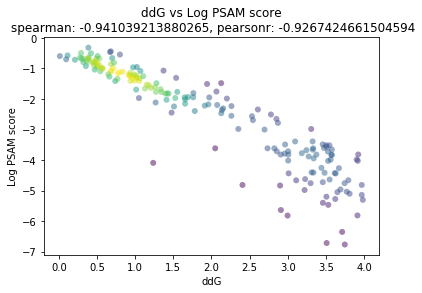

In [32]:
xvals = []
yvals = []

for seq in seqToDdg:
    yvals.append(get_PSAM_score(seq, GR_PSAM))
    xvals.append(np.mean(seqToDdg[seq]))

yvals = R*T*np.log(yvals)
    
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("Log PSAM score")
plt.title("ddG vs Log PSAM score\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

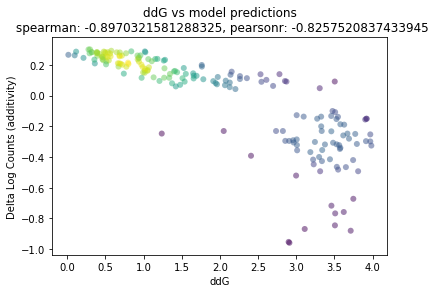

In [33]:
xvals = []
yvals = []

for c_seq in seqToDdg:
    score = seqToDeltaLogCount[consensus]
    seq = c_seq[1:16]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    yvals.append(score)
    xvals.append(np.mean(seqToDdg[c_seq]))

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("Delta Log Counts (additivity)")
plt.title("ddG vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

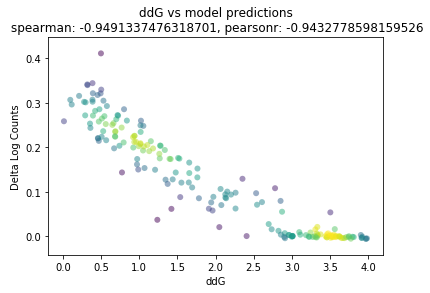

In [34]:
for curr_seq in seqToDdg:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(peaks), num_samples, replace=False)
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, curr_seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    seqToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])
    
xvals = []
yvals = []

for seq in seqToDdg:
    yvals.append(seqToDeltaLogCount[seq])
    xvals.append(np.mean(seqToDdg[seq]))

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("Delta Log Counts")
plt.title("ddG vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [122]:
diff_spacer_seqs = []
for seq in seqToDdg.keys():
    loc1 = seq.find("ACA")
    loc2 = seq.find("TGT")
    if loc1 == -1 or loc2 == -1: continue
    if abs(loc2-loc1) != 6 and np.mean(seqToDdg[seq]) <= 3:
        diff_spacer_seqs.append(seq)

In [127]:
len(diff_spacer_seqs), len(seqToDdg.keys())

(10, 188)

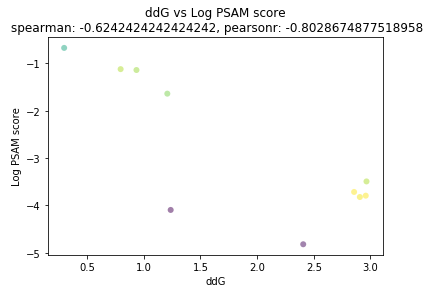

In [123]:
xvals = []
yvals = []

for seq in diff_spacer_seqs:
    yvals.append(get_PSAM_score(seq, GR_PSAM))
    xvals.append(np.mean(seqToDdg[seq]))

yvals = R*T*np.log(yvals)
    
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("Log PSAM score")
plt.title("ddG vs Log PSAM score\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

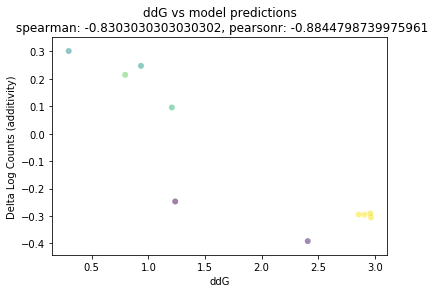

In [124]:
xvals = []
yvals = []

for c_seq in diff_spacer_seqs:
    score = seqToDeltaLogCount[consensus]
    seq = c_seq[1:16]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    yvals.append(score)
    xvals.append(np.mean(seqToDdg[c_seq]))

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("Delta Log Counts (additivity)")
plt.title("ddG vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

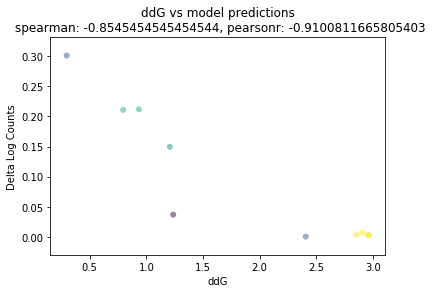

In [125]:
xvals = []
yvals = []

for seq in diff_spacer_seqs:
    yvals.append(seqToDeltaLogCount[seq])
    xvals.append(np.mean(seqToDdg[seq]))

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("Delta Log Counts")
plt.title("ddG vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

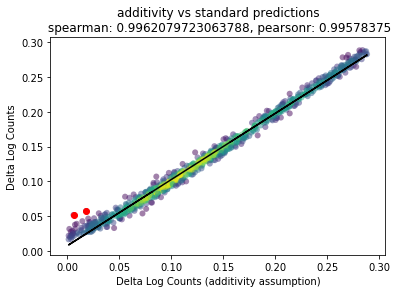

In [35]:
xvals = []
yvals = []

zoomed_seqs = []
for seq in seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    if score >= -0:
        zoomed_seqs.append(seq)
        xvals.append(score)
        yvals.append(seqToDeltaLogCount[seq])

lr_model = LinearRegression()
lr_model.fit(np.array(xvals).reshape(-1, 1), yvals)
preds = lr_model.predict(np.array(xvals).reshape(-1, 1))
dists = np.abs(yvals - preds)

outlierseqs = []
outlierx = []
outliery = []
threshold = 0.025
for idx, dist in enumerate(dists):
    if dist >= threshold:
        outlierseqs.append(zoomed_seqs[idx])
        outlierx.append(xvals[idx])
        outliery.append(yvals[idx])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
plt.plot(xvals, preds,color='k')
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
ax.scatter(outlierx, outliery, c='r', alpha=1)
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [36]:
print('0123456789')
for ids, s in enumerate(outlierseqs):
    print(s, outlierx[ids], outliery[ids])
    for idx, c1 in enumerate(consensus):
        if c1 != s[idx]:
            print(idx)

0123456789
ATTGCACCTTGTTCT 0.005860418 0.05153021
1
3
AATGCACCTTGTTCT 0.017931163 0.057275936
1
3


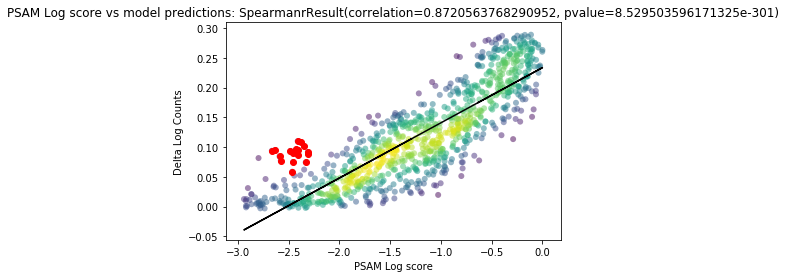

In [37]:
xvals = []
yvals = []

zoomed_seqs = []
for seq in seqs:
    if R*T*np.log(seqToPSAMScore[seq]) >= -3:
        zoomed_seqs.append(seq)
        xvals.append(seqToPSAMScore[seq])
        yvals.append(seqToDeltaLogCount[seq])

xvals = R*T*np.log(xvals)

lr_model = LinearRegression()
lr_model.fit(xvals.reshape(-1, 1), yvals)
preds = lr_model.predict(xvals.reshape(-1, 1))
dists = yvals - preds #np.abs(yvals - preds)

outlierseqs = []
outlierx = []
outliery = []
threshold = 0.05
for idx, dist in enumerate(dists):
    if dist >= threshold and xvals[idx] <= -2.0 and xvals[idx] >= -2.7 and yvals[idx] >= 0.05:
        outlierseqs.append(zoomed_seqs[idx])
        outlierx.append(xvals[idx])
        outliery.append(yvals[idx])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
plt.plot(xvals, preds,color='k')
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
ax.scatter(outlierx, outliery, c='r', alpha=1)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts")
plt.title("PSAM Log score vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

In [38]:
print('0123456789')
for ids, s in enumerate(outlierseqs):
    print(s, outlierx[ids], outliery[ids])
    for idx, c1 in enumerate(consensus):
        if c1 != s[idx]:
            print(idx)

0123456789
AGAAGACCTTGTTCT -2.348014338458342 0.10107176
2
4
AGTAGGCCTTGTTCT -2.5773680334276095 0.0772348
4
5
AGTAGAACTTGTTCT -2.5896940121698697 0.08432829
4
6
AGTAGACCTTGTCCT -2.331778675794582 0.07432004
4
12
AGTAGACGTTGTTCT -2.6332242715973293 0.09515415
4
7
AGTAGACCTTGTTCT -2.308429262875727 0.08859689
4
AGCAGACCTTGTTCT -2.464277474859572 0.05865003
2
4
AGTAGACCTTGTACT -2.4595856822172677 0.09045151
4
12
AGTAGACCCTGTTCT -2.412537781416306 0.087201975
4
8
AGTAGACCTTGTTCC -2.665310101541526 0.09374111
4
14
AGGAGACCTTGTTCT -2.4548880603701453 0.0749682
2
4
AGTAGACCGTGTTCT -2.410900573317432 0.109977834
4
8
AGTAGACCATGTTCT -2.3816058019310447 0.108432524
4
8
AGTAGACATTGTTCT -2.408070250155812 0.094999544
4
7
AGTAGACTTTGTTCT -2.3102519140224 0.091680735
4
7
GGTAGACCTTGTTCT -2.424367800004914 0.0961714
0
4
AGTAGATCTTGTTCT -2.4828212133089385 0.093527414
4
6


In [39]:
consensus = "AGTACACCTTGTTCT"
focused_seqs = []
for idx in [3, 4, 5]:
    for cx in ['A', 'C', 'G', 'T']:
        for idy in [9, 10, 11]:
            for cy in ['A', 'C', 'G', 'T']:
                new_seq = list(consensus)
                new_seq[idx] = cx
                new_seq[idy] = cy
                focused_seqs.append("".join(new_seq))
focused_seqs = list(set(focused_seqs))

In [40]:
len(focused_seqs)

100

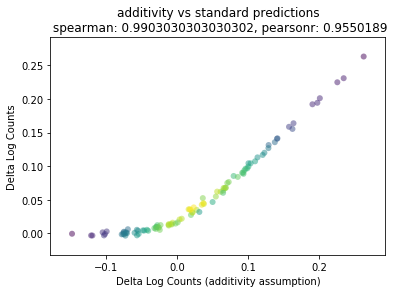

In [41]:
xvals = []
yvals = []

for seq in focused_seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    xvals.append(score)
    yvals.append(seqToDeltaLogCount[seq])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

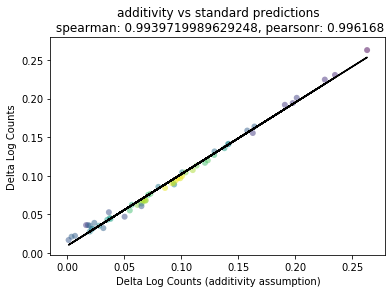

In [42]:
xvals = []
yvals = []

zoomed_seqs = []
for seq in focused_seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    if score >= 0:
        zoomed_seqs.append(seq)
        xvals.append(score)
        yvals.append(seqToDeltaLogCount[seq])

lr_model = LinearRegression()
lr_model.fit(np.array(xvals).reshape(-1, 1), yvals)
preds = lr_model.predict(np.array(xvals).reshape(-1, 1))
dists = np.abs(yvals - preds)

outlierseqs = []
outlierx = []
outliery = []
threshold = 0.025
for idx, dist in enumerate(dists):
    if dist >= threshold:
        outlierseqs.append(zoomed_seqs[idx])
        outlierx.append(xvals[idx])
        outliery.append(yvals[idx])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
plt.plot(xvals, preds,color='k')
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
ax.scatter(outlierx, outliery, c='r', alpha=1)
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

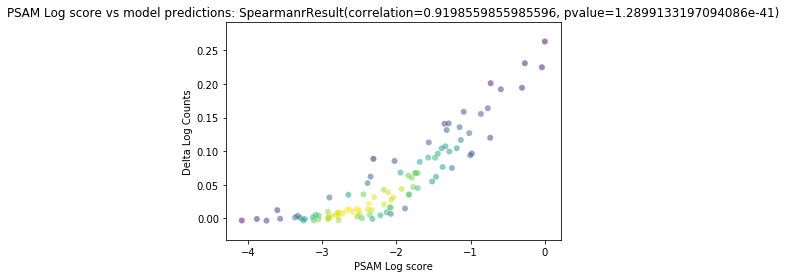

In [43]:
xvals = []
yvals = []

for seq in focused_seqs:
    xvals.append(seqToPSAMScore[seq])
    yvals.append(seqToDeltaLogCount[seq])

xvals = R*T*np.log(xvals)

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts")
plt.title("PSAM Log score vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

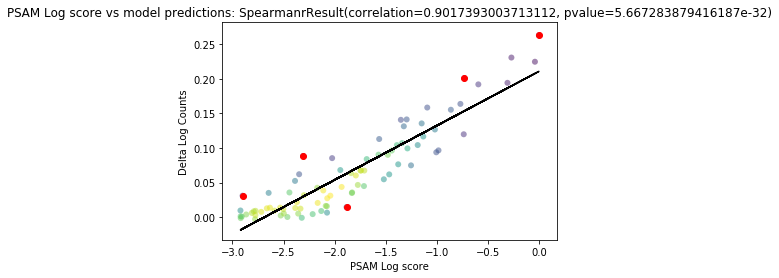

In [44]:
xvals = []
yvals = []

zoomed_seqs = []
for seq in focused_seqs:
    if R*T*np.log(seqToPSAMScore[seq]) >= -3:
        zoomed_seqs.append(seq)
        xvals.append(seqToPSAMScore[seq])
        yvals.append(seqToDeltaLogCount[seq])

xvals = R*T*np.log(xvals)

lr_model = LinearRegression()
lr_model.fit(xvals.reshape(-1, 1), yvals)
preds = lr_model.predict(xvals.reshape(-1, 1))
dists = np.abs(yvals - preds)

outlierseqs = []
outlierx = []
outliery = []
threshold = 0.045
for idx, dist in enumerate(dists):
    if dist >= threshold:
        outlierseqs.append(zoomed_seqs[idx])
        outlierx.append(xvals[idx])
        outliery.append(yvals[idx])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
plt.plot(xvals, preds,color='k')
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
ax.scatter(outlierx, outliery, c='r', alpha=1)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts")
plt.title("PSAM Log score vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

In [45]:
print('0123456789')
for ids, s in enumerate(outlierseqs):
    print(s, outlierx[ids], outliery[ids])
    for idx, c1 in enumerate(consensus):
        if c1 != s[idx]:
            print(idx)

0123456789
AGTAGACCTTGTTCT -2.308429262875727 0.08859689
4
AGTAGACCTAGTTCT -2.9011174467486183 0.031146942
4
9
AGTACACCTTGTTCT 0.0 0.26304486
AGTGCACCTTGCTCT -1.8833377742745754 0.014672348
3
11
AGTACTCCTTGTTCT -0.7296918268571644 0.2010693
5


In [46]:
spacer = "AGTACACTCTTGTTCT"

In [47]:
spacer_seqs = []
for idx in range(len(spacer)):
    for cx in ['A', 'C', 'G', 'T']:
        for idy in range(idx+1, len(spacer)):
            for cy in ['A', 'C', 'G', 'T']:
                new_seq = list(spacer)
                new_seq[idx] = cx
                new_seq[idy] = cy
                spacer_seqs.append("".join(new_seq))
spacer_seqs = list(set(spacer_seqs))

In [48]:
len(spacer_seqs)

1129

In [49]:
getOneHot(pre_seqs).shape

(100, 1346, 4)

In [50]:
for curr_seq in spacer_seqs:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(peaks), num_samples, replace=False)
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, curr_seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    seqToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])
    seqToPSAMScore[curr_seq] = get_PSAM_score(curr_seq, GR_PSAM)

In [51]:
spacer_building_blocks = []
for idx in range(len(spacer)):
    for cx in ['A', 'C', 'G', 'T']:
        if spacer[idx] == cx: continue
        new_seq = list(spacer)
        new_seq[idx] = cx
        spacer_building_blocks.append("".join(new_seq))

for curr_seq in spacer_building_blocks:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(peaks), num_samples, replace=False)
    for idx in indices:
        base_seq = dinuc_shuffle(peaks[idx])
        pre_seq = fill_into_center(base_seq, spacer)
        post_seq = fill_into_center(base_seq, curr_seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    buildingBlocksToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])

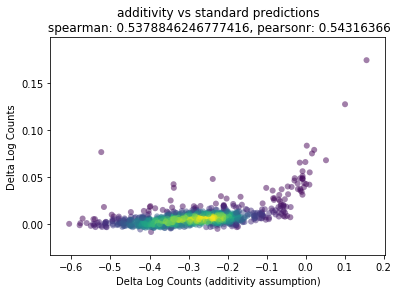

In [52]:
xvals = []
yvals = []

for seq in spacer_seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    xvals.append(score)
    yvals.append(seqToDeltaLogCount[seq])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

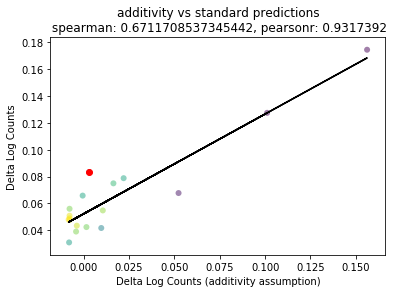

In [53]:
xvals = []
yvals = []

zoomed_seqs = []
for seq in spacer_seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    if score >= -0.01:
        zoomed_seqs.append(seq)
        xvals.append(score)
        yvals.append(seqToDeltaLogCount[seq])

lr_model = LinearRegression()
lr_model.fit(np.array(xvals).reshape(-1, 1), yvals)
preds = lr_model.predict(np.array(xvals).reshape(-1, 1))
dists = np.abs(yvals - preds)

outlierseqs = []
outlierx = []
outliery = []
threshold = 0.025
for idx, dist in enumerate(dists):
    if dist >= threshold:
        outlierseqs.append(zoomed_seqs[idx])
        outlierx.append(xvals[idx])
        outliery.append(yvals[idx])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
plt.plot(xvals, preds,color='k')
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
ax.scatter(outlierx, outliery, c='r', alpha=1)
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [54]:
print('0123456789')
for ids, s in enumerate(outlierseqs):
    print(s, outlierx[ids], outliery[ids])
    for idx, c1 in enumerate(spacer):
        if c1 != s[idx]:
            print(idx)

0123456789
AGTACATTCTGGTTCT 0.0030461992 0.083249606
6
10


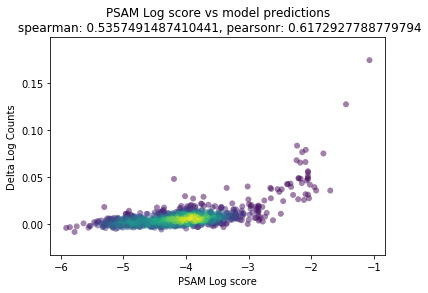

In [55]:
xvals = []
yvals = []

for seq in spacer_seqs:
    xvals.append(seqToPSAMScore[seq])
    yvals.append(seqToDeltaLogCount[seq])

xvals = R*T*np.log(xvals)

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts")
plt.title("PSAM Log score vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

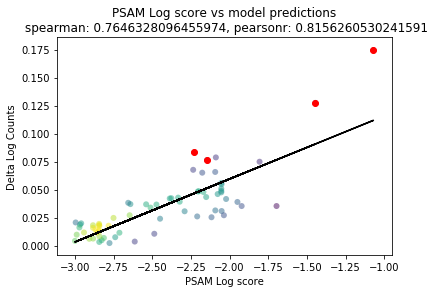

In [56]:
xvals = []
yvals = []

zoomed_seqs = []
for seq in spacer_seqs:
    if R*T*np.log(seqToPSAMScore[seq]) >= -3:
        zoomed_seqs.append(seq)
        xvals.append(seqToPSAMScore[seq])
        yvals.append(seqToDeltaLogCount[seq])

xvals = R*T*np.log(xvals)

lr_model = LinearRegression()
lr_model.fit(xvals.reshape(-1, 1), yvals)
preds = lr_model.predict(xvals.reshape(-1, 1))
dists = yvals - preds #np.abs(yvals - preds)

outlierseqs = []
outlierx = []
outliery = []
threshold = 0.025
for idx, dist in enumerate(dists):
    if dist >= threshold:
        outlierseqs.append(zoomed_seqs[idx])
        outlierx.append(xvals[idx])
        outliery.append(yvals[idx])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
plt.plot(xvals, preds,color='k')
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
ax.scatter(outlierx, outliery, c='r', alpha=1)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts")
plt.title("PSAM Log score vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [57]:
print('0123456789')
for ids, s in enumerate(outlierseqs):
    print(s, outlierx[ids], outliery[ids])
    for idx, c1 in enumerate(spacer):
        if c1 != s[idx]:
            print(idx)

0123456789
AGTACACTCTGGTCCT -1.4456079606037506 0.12744361
10
13
AGTAACCTCTTGTTCT -2.1455577769112972 0.07638404
4
5
AGTACATTCTGGTTCT -2.2274115334403524 0.083249606
6
10
AGTACACTCTGTTTCT -1.070791165949622 0.17444909
10
11


In [58]:
# focus on double mutants within same half site (with other half-site being perfect)
# does one half-site being perfect makes mutations in the other half site less severe?
consensus = "AGTACACCTTGTTCT"
focused_half_seqs = []
for idx in [9, 10, 11]:
    for cx in ['A', 'C', 'G', 'T']:
        for idy in [9, 10, 11]:
            for cy in ['A', 'C', 'G', 'T']:
                new_seq = list(consensus)
                new_seq[idx] = cx
                new_seq[idy] = cy
                focused_half_seqs.append("".join(new_seq))
focused_half_seqs = list(set(focused_half_seqs))

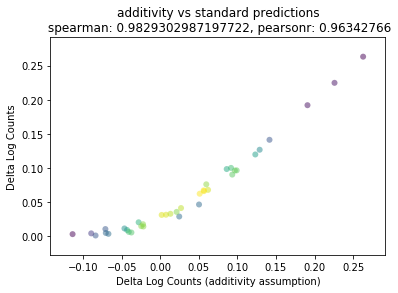

In [59]:
xvals = []
yvals = []

for seq in focused_half_seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    xvals.append(score)
    yvals.append(seqToDeltaLogCount[seq])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

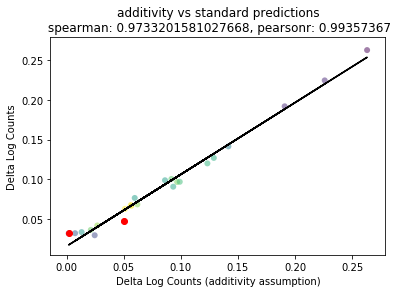

In [60]:
xvals = []
yvals = []

zoomed_seqs = []
for seq in focused_half_seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    if score >= 0:
        zoomed_seqs.append(seq)
        xvals.append(score)
        yvals.append(seqToDeltaLogCount[seq])

lr_model = LinearRegression()
lr_model.fit(np.array(xvals).reshape(-1, 1), yvals)
preds = lr_model.predict(np.array(xvals).reshape(-1, 1))
dists = np.abs(yvals - preds)

outlierseqs = []
outlierx = []
outliery = []
threshold = 0.01
for idx, dist in enumerate(dists):
    if dist >= threshold:
        outlierseqs.append(zoomed_seqs[idx])
        outlierx.append(xvals[idx])
        outliery.append(yvals[idx])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
plt.plot(xvals, preds,color='k')
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
ax.scatter(outlierx, outliery, c='r', alpha=1)
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [61]:
print('0123456789')
for ids, s in enumerate(outlierseqs):
    print(s, outlierx[ids], outliery[ids])
    for idx, c1 in enumerate(consensus):
        if c1 != s[idx]:
            print(idx)

0123456789
AGTACACCTGGCTCT 0.0018389672 0.031417962
9
11
AGTACACCTTTTTCT 0.050265774 0.046711754
10


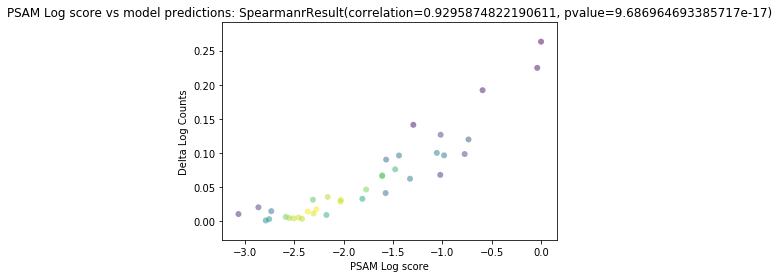

In [62]:
xvals = []
yvals = []

for seq in focused_half_seqs:
    xvals.append(seqToPSAMScore[seq])
    yvals.append(seqToDeltaLogCount[seq])

xvals = R*T*np.log(xvals)

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts")
plt.title("PSAM Log score vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

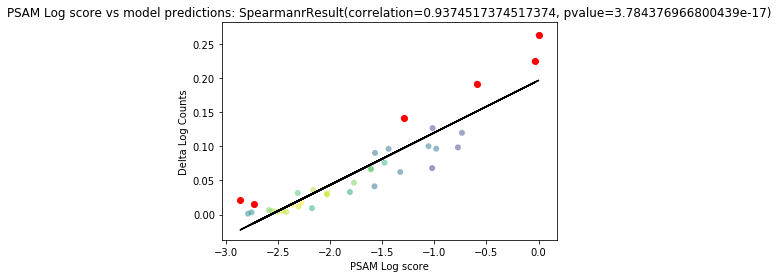

In [63]:
xvals = []
yvals = []

zoomed_seqs = []
for seq in focused_half_seqs:
    if R*T*np.log(seqToPSAMScore[seq]) >= -3:
        zoomed_seqs.append(seq)
        xvals.append(seqToPSAMScore[seq])
        yvals.append(seqToDeltaLogCount[seq])

xvals = R*T*np.log(xvals)

lr_model = LinearRegression()
lr_model.fit(xvals.reshape(-1, 1), yvals)
preds = lr_model.predict(xvals.reshape(-1, 1))
dists = yvals - preds

outlierseqs = []
outlierx = []
outliery = []
threshold = 0.025
for idx, dist in enumerate(dists):
    if dist >= threshold:
        outlierseqs.append(zoomed_seqs[idx])
        outlierx.append(xvals[idx])
        outliery.append(yvals[idx])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
plt.plot(xvals, preds,color='k')
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
ax.scatter(outlierx, outliery, c='r', alpha=1)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts")
plt.title("PSAM Log score vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

In [64]:
print('0123456789')
for ids, s in enumerate(outlierseqs):
    print(s, outlierx[ids], outliery[ids])
    for idx, c1 in enumerate(consensus):
        if c1 != s[idx]:
            print(idx)

0123456789
AGTACACCTCGTTCT -0.038721756737352245 0.22474834
9
AGTACACCTGGTTCT -1.2945655281741577 0.14137357
9
AGTACACCTTGTTCT 0.0 0.26304486
AGTACACCTAGTTCT -0.5926881838728916 0.1920301
9
AGTACACCTGCTTCT -2.864983899775095 0.020671919
9
10
AGTACACCTGATTCT -2.734715992857805 0.01503176
9
10


In [65]:
# try 2 extra and 3 extra for spacers
# try subtracting 1bp and 2bp from spacers
# try triple and 4 mutants